# What is in the datasets?

The data consists of two overarching pieces, each with subdivisions: data and simulation. In each case, the files have two names: "cuts" and "all".  The "cuts" files have applied cuts and energy corrections, and are assured to have labels in the simulation case.  The "all" files are all events from either simulation or data in that category, which has multi-site events, imperfect energy resolution, etc.

### Simulation

First, there is simulation, which contains labels where appropriate.  The simulation data was of a broad simulation of Tl208 induced events, however not all events in that simulation pass the basic cuts.  The simulation also contains the monte-carlo truth locations of the particles that originated the chits in the detector.


The simulation files are as follows:
- R6206 is the "test" run used to test performance of the networks when comparing data and monte carlo.
- R6207, R6208, R6818 and R6819 are all standard runs.
- R6700 is signal-enhanced with many more signal events.


The runs are combined into several overarching files for training:
- R6207, R6208, R6818 and R6819 are joined into a "representation_learning_tl208" prefixed file, with and without cuts, and with a train/val split.
    - `representation_learning_tl208_cuts_val.h5` has 25,904 events
    - `representation_learning_tl208_cuts_train.h5` has 212,985 events
    - `representation_learning_tl208_all_val.h5` has 64,880 events
    - `representation_learning_tl208_all_train.h5` has 537,975 events
    
- R6206 is kept separate but still has the cuts/all files:
    - R6206 "all" has 42,072 events total.
    - R6206 "cuts" has 16,839 events total.

- R6700 is folded into the eventID_tl208 files with the same files as the representation files, but only exist with the "cuts" path and train/val/test split:
    - `eventID_tl208_cuts_train.h5` has 252,902 events
    - `eventID_tl208_cuts_val.h5` has 30,816 events
    - `eventID_tl208_cuts_test.h5` has 31,623 events

No events in the `eventID_tl208_cuts_test.h5` file are present in any other file.

#### Motivation

The motivation for these splits is as follows:
- R6206 is meant to be used during training to compare data/simulation during training.
- The eventID files all have cuts applied to ensure they have valid labels for supervised training.
- The largest file, `representation_learning_tl208_all_train.h5`, is meant to be used in learning representations in an unsupervised / self-supervised way.

### Data

There are 4 data runs (7470-3), and again all runs have cuts/nocuts applied.  The event counts are:
- R7470:
    - 122,274 Events "all"
    - 15,907 Events "cuts"
- R7471:
    - 117,242 Events "all"
    - 15,239 Events "cuts"
- R7472:
    - 122,723 Events "all"
    - 15,911 Events "cuts"
- R7470:
    - 69,683 Events "all"
    - 9,037 Events "cuts"

Run 7470 is kept separate for on-the-fly comparison with simulation during training.  Runs 7471/2/3 are merged into a single file for easier processing.

# Computing Energy Distance and Statistical fitting during inference

During Training, we need to evaluate the distance between simulation and data sometimes.
We also need to compute the signal/background accuracy on data statistically (and on sim)

## Energy Distance

For energy distance, we first need to have a validation data set and validation simulation data set during training.

We have to compute a series of distances between the encoded vector for sim and data.

It isn't necessary to use the full datasets for this computation.

If local statistics are too low, we will have to perform gathers / reductions at scale
- This isn't that different from what is done with SimCLR loss, so it's easy enough.

When to compute?  Whenever there is validation simulation and validation data, energy distance should be computed and saved during training.

Default should be to reduce across all entries in the minibatch.

## Statistical Fitting

During Inference, we can compute a statistical fit after applying inference.  We need to loop through in order and capture the event energy and neural network value.  The actual fit and computations can be done single-process afterwards.

In [1]:
import numpy
import larcv
import h5py

from matplotlib import pyplot as plt
font = {'family' : 'Liberation Serif',
        # 'weight' : 'bold',
        'size'   : 22}
import matplotlib
matplotlib.rc('font', **font)

In [2]:
dataset_top = "/data/datasets/NEXT/NEXT-White-DNN-dataset/"

datasets = {
    "data" : {
        "cuts" : {
            7470 : dataset_top + "/data/larcv_merged_r7470_new_tl208_cuts_0.h5",
            7471 : dataset_top + "/data/larcv_merged_r7471_new_tl208_cuts_0.h5",
            7472 : dataset_top + "/data/larcv_merged_r7472_new_tl208_cuts_0.h5",
            7473 : dataset_top + "/data/larcv_merged_r7473_new_tl208_cuts_0.h5",
        },
        "all" : {
            7470 : dataset_top + "/data/larcv_merged_r7470_new_tl208_all_0.h5",
            7471 : dataset_top + "/data/larcv_merged_r7471_new_tl208_all_0.h5",
            7472 : dataset_top + "/data/larcv_merged_r7472_new_tl208_all_0.h5",
            7473 : dataset_top + "/data/larcv_merged_r7473_new_tl208_all_0.h5",
        },
    },
    "sim" : {
        "cuts": {
            "repr" : {
                "train" : dataset_top + "/sim/representation_learning_tl208_cuts_train.h5",
                "val"   : dataset_top + "/sim/representation_learning_tl208_cuts_val.h5",
            },
            "eventID" : {
                "train" : dataset_top + "/sim/eventID_tl208_cuts_train.h5",
                "test" : dataset_top + "/sim/eventID_tl208_cuts_test.h5",
                "val" : dataset_top + "/sim/eventID_tl208_cuts_val.h5",   
            },
            "r6206" : dataset_top + "/sim/r6206_new_tl208_cuts.h5"
        },
        "all" : {
            "repr" : {
                "train" : dataset_top + "/sim/representation_learning_tl208_all_train.h5",
                "val"   : dataset_top + "/sim/representation_learning_tl208_all_val.h5",
            },
            "r6206" : dataset_top + "/sim/r6206_new_tl208_all.h5"   
        }
    }
}


# Data/Sim Comparison in Energy

The plots below compare the 4 data runs and the eventID train files in energy (cuts only)

In [3]:
def read_event_energies(fname):
    print(fname)
    io = larcv.IOManager()
    io.add_in_file(fname)
    io.initialize()
    energies = []
    events   = []
    pdgs     = []
    for i in range(io.get_n_entries()):
        io.read_entry(i)
        particles = io.get_data("particle", "event")
        p = particles.at(0)
        e1 = p.energy_deposit()
        pdgs.append(p.pdg_code())
        energies.append(e1)
        events.append(io.event_id().event())
    io.finalize()

    return numpy.asarray(energies), numpy.asarray(events), numpy.asarray(pdgs)

The next function takes a little time to run (a few seconds):

In [4]:
energies = {}
events = {}
data_files = datasets["data"]["cuts"]
print(data_files)
for r in data_files.keys():
    en, ev, _ = read_event_energies(data_files[r])
    energies[r] = en
    events[r] = ev

{7470: '/data/datasets/NEXT/NEXT-White-DNN-dataset//data/larcv_merged_r7470_new_tl208_cuts_0.h5', 7471: '/data/datasets/NEXT/NEXT-White-DNN-dataset//data/larcv_merged_r7471_new_tl208_cuts_0.h5', 7472: '/data/datasets/NEXT/NEXT-White-DNN-dataset//data/larcv_merged_r7472_new_tl208_cuts_0.h5', 7473: '/data/datasets/NEXT/NEXT-White-DNN-dataset//data/larcv_merged_r7473_new_tl208_cuts_0.h5'}
/data/datasets/NEXT/NEXT-White-DNN-dataset//data/larcv_merged_r7470_new_tl208_cuts_0.h5
    [NORMAL]  <IOManager::prepare_input> Opening a file in READ mode: "/data/datasets/NEXT/NEXT-White-DNN-dataset//data/larcv_merged_r7470_new_tl208_cuts_0.h5"
    [NORMAL]  <IOManager::prepare_input> File "/data/datasets/NEXT/NEXT-White-DNN-dataset//data/larcv_merged_r7470_new_tl208_cuts_0.h5" has 15907 entries
    [NORMAL]  <IOManager::initialize> Prepared input with 15907 entries...


/data/datasets/NEXT/NEXT-White-DNN-dataset//data/larcv_merged_r7471_new_tl208_cuts_0.h5
    [NORMAL]  <IOManager::prepare_input> Opening a file in READ mode: "/data/datasets/NEXT/NEXT-White-DNN-dataset//data/larcv_merged_r7471_new_tl208_cuts_0.h5"
    [NORMAL]  <IOManager::prepare_input> File "/data/datasets/NEXT/NEXT-White-DNN-dataset//data/larcv_merged_r7471_new_tl208_cuts_0.h5" has 15239 entries
    [NORMAL]  <IOManager::initialize> Prepared input with 15239 entries...
/data/datasets/NEXT/NEXT-White-DNN-dataset//data/larcv_merged_r7472_new_tl208_cuts_0.h5
    [NORMAL]  <IOManager::prepare_input> Opening a file in READ mode: "/data/datasets/NEXT/NEXT-White-DNN-dataset//data/larcv_merged_r7472_new_tl208_cuts_0.h5"
    [NORMAL]  <IOManager::prepare_input> File "/data/datasets/NEXT/NEXT-White-DNN-dataset//data/larcv_merged_r7472_new_tl208_cuts_0.h5" has 15911 entries
    [NORMAL]  <IOManager::initialize> Prepared input with 15911 entries...
/data/datasets/NEXT/NEXT-White-DNN-dataset//da

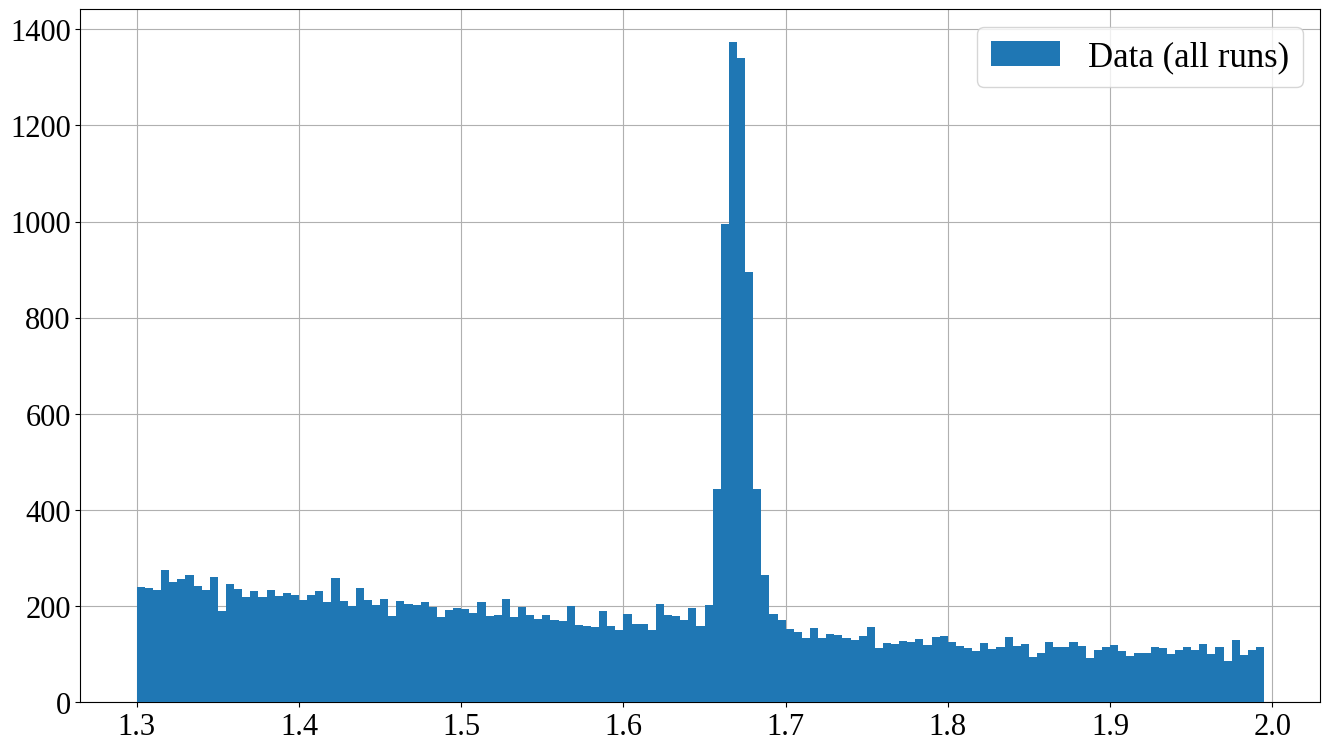

In [5]:
bins = numpy.arange(1.3, 2.0, 0.005)

fig = plt.figure(figsize=(16,9))

total_hist = numpy.zeros_like(bins[1:])

for r in energies.keys():
    hist, edges = numpy.histogram(energies[r], bins=bins)

    bin_centers = 0.5*(edges[1:] + edges[:-1])
    bin_widths  = edges[1:] - edges[:-1]

    total_hist += hist

plt.bar(bin_centers, total_hist, width=bin_widths, zorder=3, label="Data (all runs)")
plt.legend(fontsize=25)

plt.grid(True)


In [6]:
sim_energy, sim_evt, sim_label = read_event_energies(datasets["sim"]["cuts"]["eventID"]["train"])

/data/datasets/NEXT/NEXT-White-DNN-dataset//sim/eventID_tl208_cuts_train.h5
    [NORMAL]  <IOManager::prepare_input> Opening a file in READ mode: "/data/datasets/NEXT/NEXT-White-DNN-dataset//sim/eventID_tl208_cuts_train.h5"
    [NORMAL]  <IOManager::prepare_input> File "/data/datasets/NEXT/NEXT-White-DNN-dataset//sim/eventID_tl208_cuts_train.h5" has 252902 entries
    [NORMAL]  <IOManager::initialize> Prepared input with 252902 entries...


Text(0.5, 0, 'Energy [MeV]')

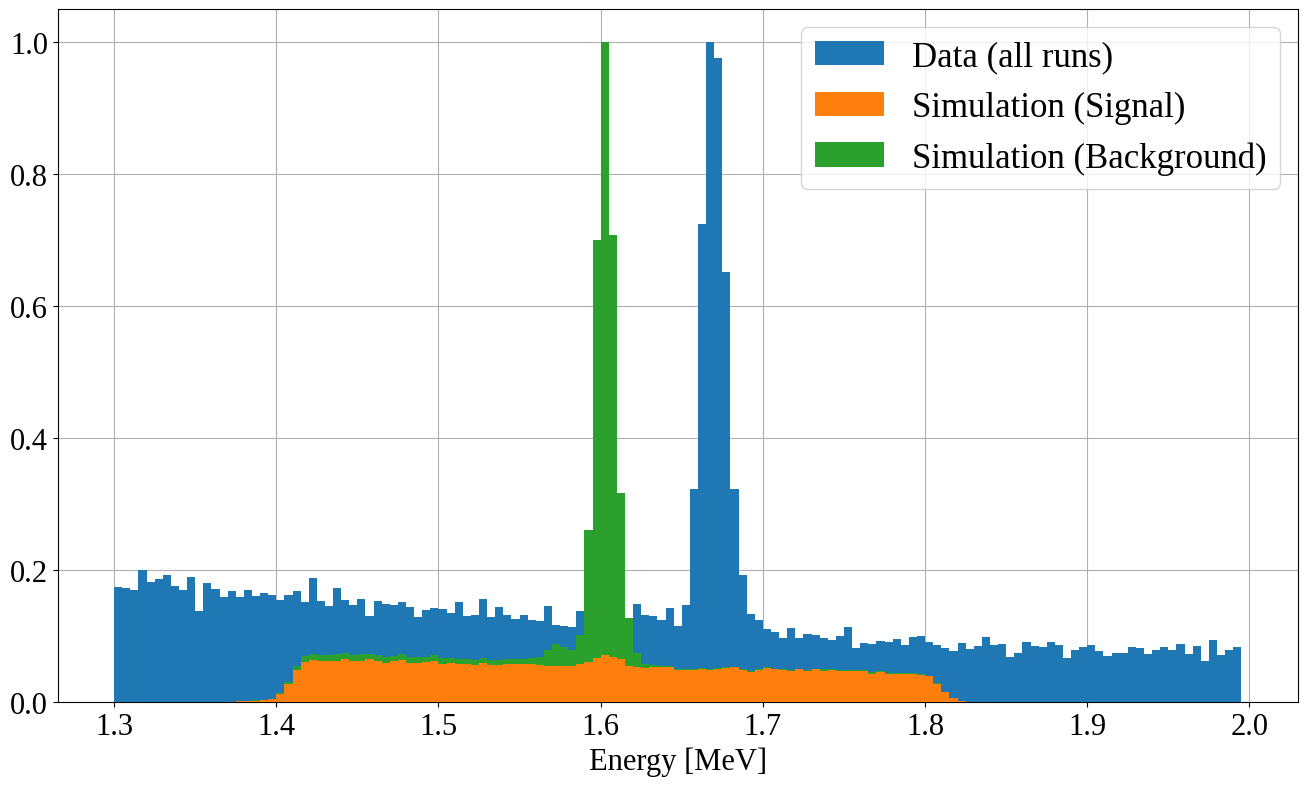

In [7]:

fig = plt.figure(figsize=(16,9))

sig_energy = sim_energy[sim_label == 1]
bkg_energy = sim_energy[sim_label == 0]

sig_hist, _ = numpy.histogram(sig_energy, bins=bins)
bkg_hist, _ = numpy.histogram(bkg_energy, bins=bins)

sim_norm = numpy.max(sig_hist + bkg_hist)

sig_hist = sig_hist / sim_norm
bkg_hist = bkg_hist / sim_norm
total_hist = total_hist / numpy.max(total_hist)

plt.bar(bin_centers, total_hist, width=bin_widths, zorder=3, label="Data (all runs)")
plt.bar(bin_centers, bkg_hist, width=bin_widths, zorder=3, label="Simulation (Signal)")
plt.bar(bin_centers, sig_hist, bottom=bkg_hist, width=bin_widths, zorder=3, label="Simulation (Background)")
plt.legend(fontsize=25)

plt.grid(True)

plt.xlabel("Energy [MeV]")

Seen above, the two histograms are peaked at slightly different values.  This isn't a problem in training since all the events are normalized to have an energy of 1.0 and then some smearing is applied, as well.

We do statistical measurement of efficiencies by fitting these plots.  Since the two histograms are slightly different, we use different fit parameters and bounds for each.

In [8]:
from dataclasses import dataclass
from omegaconf import OmegaConf

@dataclass
class FitSeed:
    exp_norm:    float
    exp_tau:     float
    gauss_norm:  float
    gauss_mu:    float
    gauss_sigma: float

@dataclass
class FitParams:
    seed:  FitSeed
    min_e: float = 1.5
    max_e: float = 1.75
    bin_e: float = 0.005


In [9]:
from src.fitting.fit_functions import expgauss, fit

In [10]:
#Fit the simulation data:

sim_seed   = FitSeed(1e5, 0.45, 200, 1.65, 0.05)
sim_params = OmegaConf.structured( FitParams(seed = sim_seed))

bins = numpy.arange(sim_params.min_e, sim_params.max_e, sim_params.bin_e)
sim_energies, edges = numpy.histogram(sim_energy, bins)
bin_centers = 0.5*(edges[1:] + edges[:-1])
bin_widths = edges[1:] - edges[:-1]


sim_f, sim_fit_vals, errors = fit(expgauss, bin_centers, sim_energies, seed = sim_params.seed)



Seed:  (100000.0, 0.45, 200.0, 1.65, 0.05)


/home/cadams/NEXT/NEXT_SparseEventID/src/fitting/fit_functions.py:10: RuntimeWarning: invalid value encountered in scalar power
  return gauss_norm/((gauss_sigma * 2*numpy.pi)**.5) * numpy.exp(-0.5*(x-gauss_mu)**2./gauss_sigma**2.)


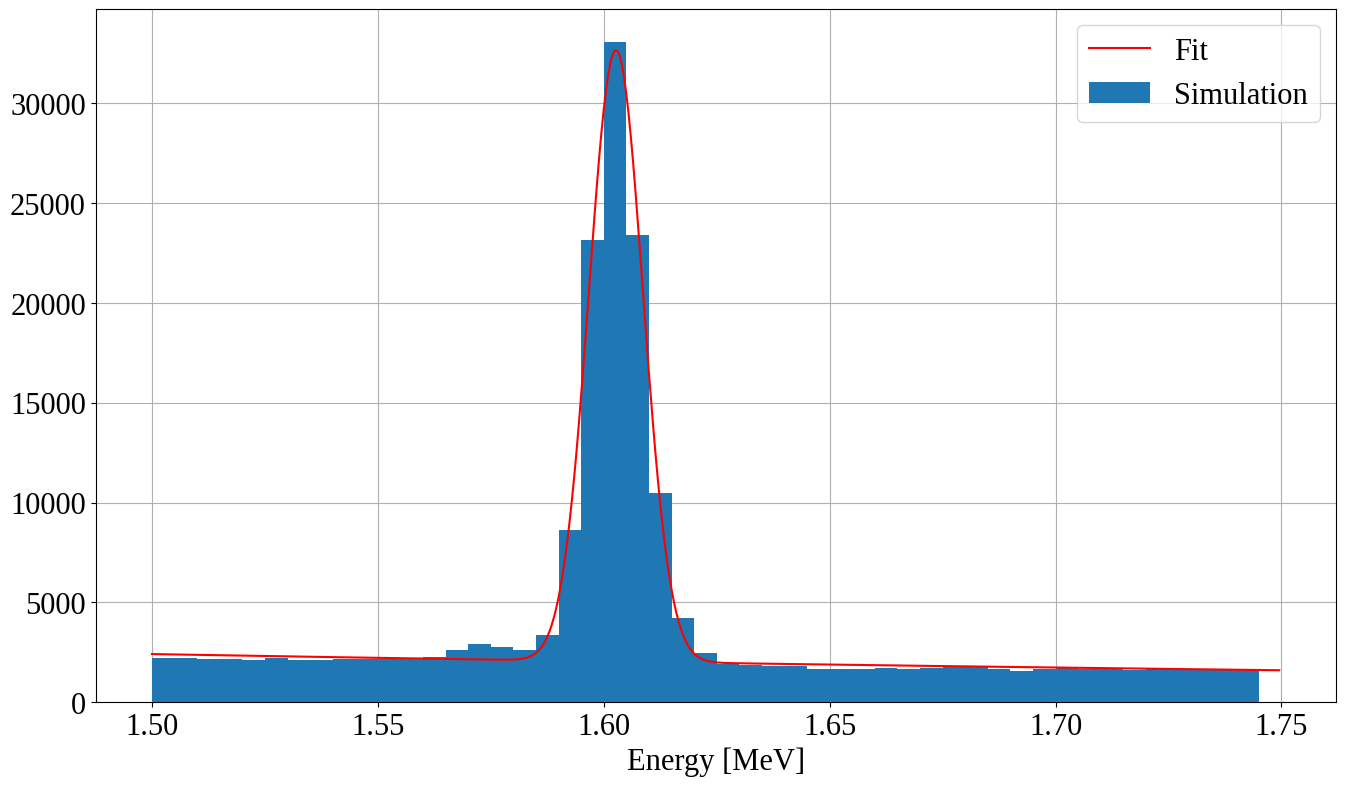

In [11]:
fig = plt.figure(figsize=(16,9))
plt.bar(bin_centers, sim_energies, width=bin_widths, zorder=3, label="Simulation")

high_res_bins = numpy.arange(sim_params.min_e, sim_params.max_e, 0.1*sim_params.bin_e)

plt.plot(high_res_bins, sim_f(high_res_bins), color="red", zorder=4, label="Fit")

plt.xlabel("Energy [MeV]")
plt.legend()

plt.grid(True)

In [12]:
#Fit the real data:

data_seed   = FitSeed(1e5, 0.45, 200, 1.67, 0.05)
data_params = OmegaConf.structured( FitParams(seed = data_seed))

bins = numpy.arange(data_params.min_e, data_params.max_e, data_params.bin_e)
bin_centers = 0.5*(edges[1:] + edges[:-1])
bin_widths = edges[1:] - edges[:-1]

data_energies = numpy.zeros(len(bin_centers))

for r in energies.keys():
    local_hist, edges = numpy.histogram(energies[r], bins=bins)
    data_energies += local_hist


data_f, data_fit_vals, errors = fit(expgauss, bin_centers, data_energies, seed = data_params.seed)



Seed:  (100000.0, 0.45, 200.0, 1.67, 0.05)


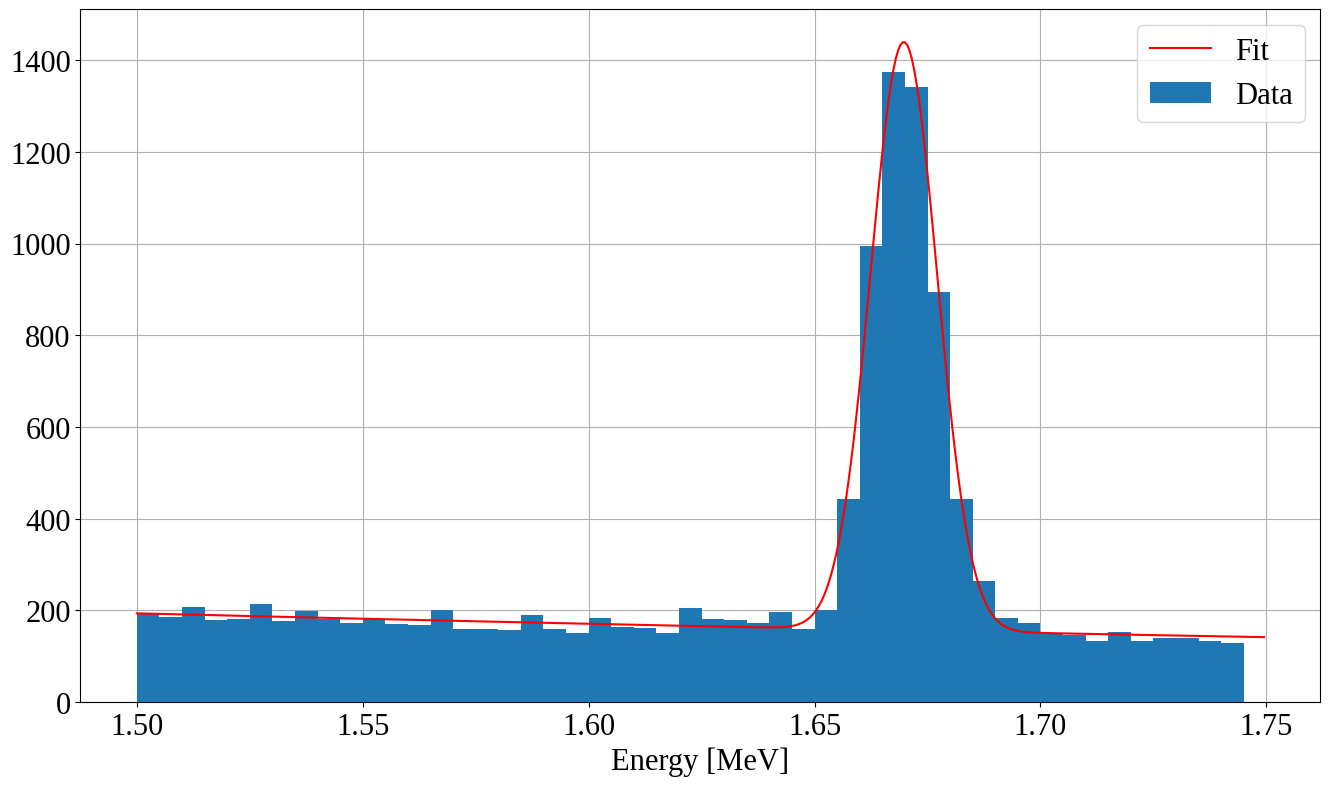

In [13]:
fig = plt.figure(figsize=(16,9))
plt.bar(bin_centers, data_energies, width=bin_widths, zorder=3, label="Data")

high_res_bins = numpy.arange(data_params.min_e, data_params.max_e, 0.1*data_params.bin_e)

plt.plot(high_res_bins, data_f(high_res_bins), color="red", zorder=4, label="Fit")

plt.xlabel("Energy [MeV]")
plt.legend()

plt.grid(True)

In [29]:
from scipy.optimize import curve_fit
import numpy as np
import numpy

# from src.fitting.fit_functions import expgauss
from scipy.optimize import curve_fit


def gauss(x, exp_norm, exp_tau, gauss_norm, gauss_mu, gauss_sigma):
    return gauss_norm/((gauss_sigma * 2*numpy.pi)**.5) * numpy.exp(-0.5*(x-gauss_mu)**2./gauss_sigma**2.)

def exp(x, exp_norm, exp_tau, gauss_norm, gauss_mu, gauss_sigma):
    return exp_norm * numpy.exp(- x/exp_tau) 

def expgauss(x, exp_norm, exp_tau, gauss_norm, gauss_mu, gauss_sigma):
    return exp(x, exp_norm, exp_tau, gauss_norm, gauss_mu, gauss_sigma) \
        + gauss(x, exp_norm, exp_tau, gauss_norm, gauss_mu, gauss_sigma)
    # return exp_norm * numpy.exp(x/exp_tau) + gauss_norm/(2*numpy.pi)**.5/gauss_sigma * numpy.exp(-0.5*(x-gauss_mu)**2./gauss_sigma**2.)

def get_errors(cov):
    """
    Find errors from covariance matrix
    Parameters
    ----------
    cov : np.ndarray
        Covariance matrix of the fit parameters.
    Returns
    -------
    err : 1-dim np.ndarray
        Errors asociated to the fit parameters.
    """
    return numpy.sqrt(numpy.diag(cov))


def fit(func, x, y, seed : dict = {}, fit_range=None, **kwargs):
    if fit_range is not None:
        sel = (fit_range[0] <= x) & (x < fit_range[1])
        x, y = x[sel], y[sel]
        
    # Coerce the seed (which is a dict) into a tuple of properly ordered args
    seed = (
        seed["exp_norm"],
        seed["exp_tau"],
        seed["gauss_norm"],
        seed["gauss_mu"],
        seed["gauss_sigma"],
    )

    print("Seed: ", seed)

    vals, cov = curve_fit(func, x, y, seed, **kwargs)
    
    
    # Repack the vals into a dict to make them easier to comprehend:

    vals = {
        "exp_norm"    : vals[0],
        "exp_tau"     : vals[1],
        "gauss_norm"  : vals[2],
        "gauss_mu"    : vals[3],
        "gauss_sigma" : vals[4],
    }

    fitf = lambda x: func(x, **vals)


    return fitf, vals, get_errors(cov)

def fit_energies_with_mask(energies, fit_params, mask = None, override_seed = None):
    """Perform the fit, with optional mask on energies.

    Returns the fit function 

    Args:
        energies (_type_): _description_
        fit_params (_type_): _description_
        mask (_type_, optional): _description_. Defaults to None.
    """

    # First, bin the energies:
    bins = numpy.arange(fit_params.min_e, fit_params.max_e, fit_params.bin_e)
    
    if mask is not None:
        energies = energies[mask]

    

    binned_energies, edges = numpy.histogram(energies, bins=bins)
    bin_centers = 0.5*(edges[1:] + edges[:-1])
    bin_widths = edges[1:] - edges[:-1]


    fit_seed = fit_params.seed if override_seed is None else override_seed

    # Do the fit:
    fit_f, vals, errors = fit(expgauss, bin_centers, binned_energies, seed = fit_seed)

    return fit_f, vals, errors

In [46]:
# Demonstrate fitting the initial curve, and then fitting the subsequent cut curves

merged_runs = numpy.concatenate((energies[7470], energies[7471], energies[7472]))

data_fit_f, data_fit_vals, _ = fit_energies_with_mask(merged_runs, data_params)

width = 0.1*data_params.bin_e
high_res_bins = numpy.arange(data_params.min_e, data_params.max_e, width)

gauss_integral = numpy.sum(gauss(high_res_bins, **data_fit_vals)*width,)
print(gauss_integral)

exp_integral = numpy.sum(exp(high_res_bins, **data_fit_vals)*width,)

print(exp_integral)

print()


[1.06932924 1.12604978 1.94177717 ... 1.24262884 1.52725075 1.26412046]
{'exp_norm': 100000.0, 'exp_tau': 0.45, 'gauss_norm': 200.0, 'gauss_mu': 1.67, 'gauss_sigma': 0.05}
[ 166  155  174  155  154  180  147  166  147  150  155  143  156  177
  140  134  126  162  117  125  157  136  143  124  171  156  149  137
  172  134  170  365  840 1159 1108  740  375  216  149  143  127  117
  114  129  115  131  115  110  109]
[1.5025 1.5075 1.5125 1.5175 1.5225 1.5275 1.5325 1.5375 1.5425 1.5475
 1.5525 1.5575 1.5625 1.5675 1.5725 1.5775 1.5825 1.5875 1.5925 1.5975
 1.6025 1.6075 1.6125 1.6175 1.6225 1.6275 1.6325 1.6375 1.6425 1.6475
 1.6525 1.6575 1.6625 1.6675 1.6725 1.6775 1.6825 1.6875 1.6925 1.6975
 1.7025 1.7075 1.7125 1.7175 1.7225 1.7275 1.7325 1.7375 1.7425]
Seed:  (100000.0, 0.45, 200.0, 1.67, 0.05)
19.751129614825793
35.05676641588367



/tmp/ipykernel_33860/1734183633.py:10: RuntimeWarning: invalid value encountered in scalar power
  return gauss_norm/((gauss_sigma * 2*numpy.pi)**.5) * numpy.exp(-0.5*(x-gauss_mu)**2./gauss_sigma**2.)


In [55]:
# With only changing the mask, redo the fit:
scores = numpy.random.uniform(size=len(merged_runs))
print(scores)
mask = scores > 0.5
print(mask)
# We should see a uniform decrease of integral values by 50%

# Use teh previous fit as the new seed:
masked_fit_f, masked_fit_vals, _ = fit_energies_with_mask(
    merged_runs, data_params, mask=mask, override_seed=data_fit_vals)

width = 0.1*data_params.bin_e
high_res_bins = numpy.arange(data_params.min_e, data_params.max_e, width)

masked_gauss_integral = numpy.sum(gauss(high_res_bins, **masked_fit_vals)*width,)
print(2*masked_gauss_integral)

masked_exp_integral = numpy.sum(exp(high_res_bins, **masked_fit_vals)*width,)

print(2*masked_exp_integral)

print()


[0.25981674 0.38194129 0.18464586 ... 0.10509188 0.97130502 0.6723708 ]
[False False False ... False  True  True]
[1.27104671 1.41804089 2.45904043 ... 1.1577624  1.52725075 1.26412046]
{'exp_norm': 1129.9123638023743, 'exp_tau': 0.7770422601761029, 'gauss_norm': 230.45811190581225, 'gauss_mu': 1.6696749313075938, 'gauss_sigma': 0.007345136636550486}
[ 96  85  84  77  67  90  67  81  72  61  70  62  82 102  74  62  64  82
  61  64  80  74  61  66  86  77  71  60  91  77  93 195 429 552 538 373
 189 116  72  71  65  55  53  63  59  74  61  47  48]
[1.5025 1.5075 1.5125 1.5175 1.5225 1.5275 1.5325 1.5375 1.5425 1.5475
 1.5525 1.5575 1.5625 1.5675 1.5725 1.5775 1.5825 1.5875 1.5925 1.5975
 1.6025 1.6075 1.6125 1.6175 1.6225 1.6275 1.6325 1.6375 1.6425 1.6475
 1.6525 1.6575 1.6625 1.6675 1.6725 1.6775 1.6825 1.6875 1.6925 1.6975
 1.7025 1.7075 1.7125 1.7175 1.7225 1.7275 1.7325 1.7375 1.7425]
Seed:  (1129.9123638023743, 0.7770422601761029, 230.45811190581225, 1.6696749313075938, 0.00734513